# OISST Timeseries - Large Marine Ecosystems

**ABOUT:**
Timelines of temperature anomalies, their variance, and their likelihood within the scope of each large marine ecosystem.

## Product 4. OISST Regional Timeseries


**Objective: Calculate full sea surface temperature histories for the large marine ecosystems**

In [3]:
# Load Packages
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
import geopandas as gpd
import regionmask
import math
import oisstools as ot

# Set the workspace - local/ docker
box_root = ot.set_workspace("local")

# variable name to mask and make timeline from
var_name = "sst"

## Step 1: Load LME Polygons

As a favor for myself I originally put all the large marine ecosystems and their file paths into a csv file so I would not need to loop over the names for this time around.

Now lookup functions have been added to oisstools.py that make sure that everything matches.

In [4]:
# Get their names from lookup catalog
update_regions = "lme"
region_names = ot.get_region_names(region_group = update_regions)
print(f"Processing Timeseries for: {update_regions}")
# for region in region_names:
#     print(f" - {region}")

Processing Timeseries for: lme


agulhas_current


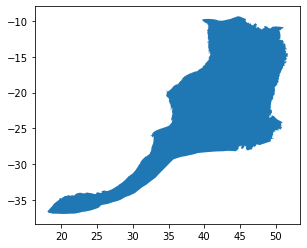

In [5]:
# Get paths to each shapefile
mask_paths = ot.get_timeseries_paths(box_root = box_root, 
                                     region_list = region_names, 
                                     region_group = update_regions, 
                                     polygons = True)

# Use paths to make list of loaded polygons
mask_list = []
for mask_path_i in mask_paths:
    mask_shape = gpd.read_file(mask_path_i)
    mask_list.append(mask_shape)
    #print(f"Loading Mask Area :  {mask_path_i}")

print(region_names[0])    
mask_list[0].plot()

In [6]:
# # This csv contains naming/number structure for the Large Marine Ecosystems
# lme_info = pd.read_csv(f"{box_root}NSF OKN Demo Data/large_marine_ecosystems/lme_names_key.csv").sort_values("lme_name")
# lme_info.head()

In [7]:
# # Load polygons using the table
# lme_polys = []
# for i, area_path in lme_info.iterrows():
#     shape = gpd.read_file(f"{box_root}NSF OKN Demo Data/large_marine_ecosystems/{area_path.full_poly_file}")
#     lme_polys.append(shape)

# # Plot a single area - Agulhas Current
# lme_polys[0].plot()

## Step 2: Load OISST Collection

Timelines for these area haven't been calculates yet so it should be possible to do the full thing all at once. Steps are to load the observed data, get what the mean sst is for every day as a timeseries, as well as what the climatology is for that day of the year.

In [8]:
# Years to Include
start_yr = 1981
end_yr = 2015

# Load OISSt using ot.load_box_oisst()
oisst_grid = ot.load_box_oisst(box_root, 
                               start_yr, 
                               end_yr, 
                               anomalies = False, 
                               do_parallel = True)
# oisst_grid.sst.isel(time = 0).plot()

# Add MOD
oisst_grid = ot.add_mod(oisst_grid, time_dim = "time")


In [9]:
# OLD Code

# # Years to Include
# start_yr = 1981
# end_yr = 2020

# # OISST Root Path
# oisst_location  = f'{box_root}RES_Data/OISST/oisst_mainstays/annual_observations/'


# # Append netcdf paths together in a list
# fpaths = []
# for yr in range(start_yr, end_yr + 1):
#     fpaths.append(f'{oisst_location}sst.day.mean.{yr}.v2.nc')

# # Lazy-load the data using xr.open_mfdataset
# oisst = xr.open_mfdataset(fpaths, combine = "by_coords", parallel = False)
# oisst


# # Add modified ordinal day, for day-to-day calculation and leapyear adjustment
# not_leap_year        = ~oisst.indexes['time'].is_leap_year
# march_or_later       = oisst.time.dt.month >= 3
# ordinal_day          = oisst.time.dt.dayofyear
# modified_ordinal_day = ordinal_day + (not_leap_year & march_or_later)

# # Assign MOD coordinate
# oisst = oisst.assign_coords(modified_ordinal_day = modified_ordinal_day)

## Step 3: Load OISST Climatology

From the global extent climatology we will want to get regional means for the areas of interest.

In [10]:
# Load the OISST Climatology
# oisst_clim = xr.open_dataset(f"{box_root}RES_Data/OISST/oisst_mainstays/daily_climatologies/daily_clims_1982to2011.nc")
oisst_clim = ot.load_oisst_climatology(box_root, reference_period = "1982-2011")
oisst_clim

<xarray.Dataset>
Dimensions:               (lat: 720, lon: 1440, modified_ordinal_day: 366)
Coordinates:
  * lat                   (lat) float32 -89.875 -89.625 ... 89.625 89.875
  * lon                   (lon) float32 0.125 0.375 0.625 ... 359.625 359.875
  * modified_ordinal_day  (modified_ordinal_day) int64 1 2 3 4 ... 364 365 366
Data variables:
    sst                   (modified_ordinal_day, lat, lon) float32 ...
Attributes:
    title:          30-Year sea surface temperature climatology from NOAA OIS...
    institution:    Gulf of Maine Research Institute
    source:         NOAA/NCDC  ftp://eclipse.ncdc.noaa.gov/pub/OI-daily-v2/
    comment:        Climatologies represent mean SST for the years 1982-2011
    history:        Climatologies calculated 3/2/2020
    references:     https://www.esrl.noaa.gov/psd/data/gridded/data.noaa.oiss...
    dataset_title:  GMRI 30-Year Climatology - OISST

## Step 4: Create Masked Timeseries

So the steps to create a masked timeseries are straightforward. Once everything is prepped you simply create a mask with the geometry of the polygon of interest. You then extract the cells that fall within it, and calculatet the mean temperature and standard deviation for the area for each time step. These steps are repeated for the raw observations as well as the climate means in order to get anomalies from the 82-2011 climatology.

In [11]:
# # Testing regional climatology
# var_name = "sst"
# clim_test = ot.calc_ts_mask(grid_obj = oisst_clim, 
#                             shp_obj  = mask_list[0], 
#                             shp_name = region_names[0],
#                             var_name = var_name,
#                             climatology = True)
# # inspecting
# clim_test.head()

In [12]:
# # Testing sst timeline
# sst_test = ot.calc_ts_mask(grid_obj = oisst_grid, 
#                            shp_obj  = mask_list[0], 
#                            shp_name = region_names[0],
#                            var_name = var_name,
#                            climatology = False)

# # inspecting
# sst_test.head()

In [13]:
# # Merging Test

# # Add MOD
# sst_mod = ot.add_mod_to_ts(sst_test)

# # Merge on MOD
# anom_timeline = sst_mod.merge(clim_test, how = "left", on = "modified_ordinal_day")

# #Set index as the date, drop time
# anom_timeline.index = anom_timeline.index = anom_timeline["time"]
# anom_timeline       = anom_timeline.drop(["time"], axis = 1)

# #Calc anoms
# anom_timeline = anom_timeline.assign(anom = anom_timeline[f"{var_name}"] - anom_timeline[f"{var_name}_clim"])
# anom_timeline = anom_timeline.rename(columns = { "anom" : f"{var_name}_anom"})

# # Reset Index
# anom_timeline = anom_timeline.reset_index()

# # re-order columns for peace of mind
# anom_timeline = anom_timeline[["time", "modified_ordinal_day", f"{var_name}", f"{var_name}_clim", f"{var_name}_anom", "clim_sd"]]
# anom_timeline.head()

In [14]:
# NEW CODE - Masked Timeseries

# list to store the update period timeseries
clim_ts = [] # climatology timeseries
obs_ts = []  # temperature observations
new_ts = []  # anomaly timeseries


# Iteratre through names and shapes simultaneously
for mask_shp, mask_name in zip(mask_list, region_names):
    
    
    
    #### 1. Get masked timeseries of climatology
    masked_clim = ot.calc_ts_mask(grid_obj = oisst_clim, 
                                  shp_obj  = mask_shp, 
                                  shp_name = mask_name,
                                  var_name = "sst",
                                  climatology = True)
    
    # Add to list
    clim_ts.append(masked_clim)
    
    
    
    #### 2. Get masked Timeseries of observations
    masked_sst = ot.calc_ts_mask(grid_obj = oisst_grid, 
                                 shp_obj  = mask_shp, 
                                 shp_name = mask_name,
                                 var_name = "sst",
                                 climatology = False)
    
    # Add MOD to observation temp ts
    masked_sst = ot.add_mod_to_ts(masked_sst)
    
    # Add to list
    obs_ts.append(masked_sst)
    

    
    
    #### 3. Merge on MOD
    
    # Merge on MOD
    anom_timeline = masked_sst.merge(masked_clim, how = "left", on = "modified_ordinal_day")

    #Set index as the date, drop time
    anom_timeline.index = anom_timeline.index = anom_timeline["time"]
    anom_timeline       = anom_timeline.drop(["time"], axis = 1)

    
    
    #### 4. Calc anoms
    anom_timeline = anom_timeline.assign(anom = anom_timeline[f"{var_name}"] - anom_timeline[f"{var_name}_clim"])
    anom_timeline = anom_timeline.rename(columns = { "anom" : f"{var_name}_anom"})

    # Reset Index
    anom_timeline = anom_timeline.reset_index()

    # re-order columns for peace of mind
    anom_timeline = anom_timeline[["time", "modified_ordinal_day", f"{var_name}", f"{var_name}_clim", f"{var_name}_anom", "clim_sd"]]
    anom_timeline.head()
    
    # Add to list
    new_ts.append(anom_timeline)
    
    print(f"{mask_name} timeseries processed.")




agulhas_current timeseries processed.
aleutian_islands timeseries processed.
antarctica timeseries processed.
arabian_sea timeseries processed.
baltic_sea timeseries processed.
barents_sea timeseries processed.
bay_of_bengal timeseries processed.
beaufort_sea timeseries processed.
benguela_current timeseries processed.
black_sea timeseries processed.
california_current timeseries processed.
canadian_eastern_arctic_west_greenland timeseries processed.
canadian_high_arctic_north_greenland timeseries processed.
canary_current timeseries processed.
caribbean_sea timeseries processed.
celtic_biscay_shelf timeseries processed.
central_arctic timeseries processed.
east_bering_sea timeseries processed.
east_brazil_shelf timeseries processed.
east_central_australian_shelf timeseries processed.
east_china_sea timeseries processed.
east_siberian_sea timeseries processed.
faroe_plateau timeseries processed.
greenland_sea timeseries processed.
guinea_current timeseries processed.
gulf_of_alaska tim

In [15]:
# Inspect one
new_ts[0].head()

,time,modified_ordinal_day,sst,sst_clim,sst_anom,clim_sd
0,1981-09-01,245,22.674397,23.260065,-0.585669,2.282113
1,1981-09-02,246,22.621262,23.264402,-0.643141,2.285316
2,1981-09-03,247,22.496183,23.269115,-0.772932,2.277643
3,1981-09-04,248,22.331186,23.283617,-0.952431,2.273174
4,1981-09-05,249,22.239838,23.292496,-1.052658,2.281082


In [10]:
# # OLD Code

# # Global Settings
# var_name  = "sst"
# grid_ds = oisst
# clim_ds = oisst_clim

# # list to store them un-appended
# new_ts = []


# ##### Super loop for all the LME's  ####
# for i, area in lme_info.iterrows():
    

#     # Grab the shape object the we are looping through
#     shp_obj = lme_polys[i] 
#     shp_name = area["lme_name"]
#     poly_name = area["lme_name"].replace(" ", "_").replace("-", "_").replace("___", "_").replace("__", "_").lower()
    
    
    
#     ##
#     # 1. Calculate Mu and Sigma from climatology for area within polygon
#     ##

#     # a. Set up naming convention for var of interest
#     clim_name = f"{var_name}_clim"
#     sd_name   = f"clim_sd"

#     # b. Make the mask
#     area_mask = regionmask.Regions(shp_obj.geometry,
#                                    name = shp_name)

#     # c. Mask the array to get nan test
#     mask = area_mask.mask(clim_ds, lon_name = "lon", lat_name = "lat")

#     # d. Extract data that falls within the mask
#     masked_ds = clim_ds.where(~np.isnan(mask))

#     # e. Calculate timeseries mean and sd
#     masked_ts = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))#
#     masked_ts[f"{sd_name}"] = getattr(masked_ds, var_name).std(dim = ("lat", "lon"))


#     # f. Format masked timeseries dataframe
#     regional_climatology = masked_ts.to_dataframe()
#     regional_climatology = regional_climatology.reset_index()
#     regional_climatology = regional_climatology.rename(columns = {f"{var_name}" : f"{clim_name}"})
    


#     ##
#     # 2. Calculate Mean Var Timeline from Observed Data for Area Within Polygon
#     ##


#     # a. Make the mask
#     area_mask = regionmask.Regions(shp_obj.geometry,
#                                    name = shp_name)

#     # b. Mask the array with gom_mask to get nan test
#     mask = area_mask.mask(grid_ds, lon_name = "lon", lat_name = "lat")

#     # c. Extract data that falls within the mask
#     masked_ds = grid_ds.where(~np.isnan(mask))

#     # d. Calculate timeseries mean and sd
#     masked_ts = getattr(masked_ds, var_name).mean(dim = ("lat", "lon"))


#     # e. Masked Timeseries Dataframe
#     regional_means = masked_ts.to_dataframe()
#     regional_means = regional_means.reset_index()
#     regional_means["time"] = pd.to_datetime(regional_means["time"])



#     ##
#     # 3. Log-Likelihood Estimate
#     ##

#     # Merge on MOD
#     anom_timeline = regional_means.merge(regional_climatology, how = "left", on = "modified_ordinal_day")

#     #Set index as the date
#     anom_timeline.index = anom_timeline.index = anom_timeline["time"]
#     anom_timeline = anom_timeline.drop(["time"], axis = 1)

#     #Calc anoms
#     anom_timeline = anom_timeline.assign(anom = anom_timeline[f"{var_name}"] - anom_timeline[f"{clim_name}"])
#     anom_timeline = anom_timeline.rename(columns = { "anom" : f"{var_name}_anom"})

#     # get likelihood
#     def calc_ll(row):
#         # log likelihood 
#         n = 1
#         anom  = row[f"{var_name}"]
#         sigma = row["clim_sd"]
#         mu    = row[f"{clim_name}"]
#         log_lik = n * math.log(2 * math.pi * (sigma ** 2)) / 2 + np.sum(((anom - mu) ** 2) / (2 * (sigma ** 2)))
#         return log_lik

#     #anom_timeline.apply(llnorm, axis = 1, args = anom_timeline[["sst_clim", "clim_sd", "sst_anom"]])
#     anom_timeline["log_lik"] = anom_timeline.apply(calc_ll, axis = 1)
#     anom_timeline = anom_timeline.reset_index()
    
#     # re-order columns for peace of mind
#     anom_timeline = anom_timeline[["time", "modified_ordinal_day", "sst", "sst_clim", "sst_anom", "clim_sd", "log_lik"]]
    
#     # add to list
#     new_ts.append(anom_timeline)
    
#     # print name for progress report
#     print(f"{shp_name} timeseries processed.")

## Validation: Table head and Plot

In [7]:
# Reminder LME 46 is US NE Shelf
new_ts[0].head()

,time,modified_ordinal_day,sst,sst_clim,sst_anom,clim_sd,log_lik
0,1981-09-01,245,5.126844,5.179364,-0.052520,2.721179,1.920190
1,1981-09-02,246,5.144029,5.130116,0.013913,2.675931,1.903249
2,1981-09-03,247,5.032818,5.101026,-0.068208,2.639488,1.889858
3,1981-09-04,248,4.911862,5.053141,-0.141279,2.604544,1.877667
4,1981-09-05,249,4.947023,4.987466,-0.040443,2.580985,1.867232


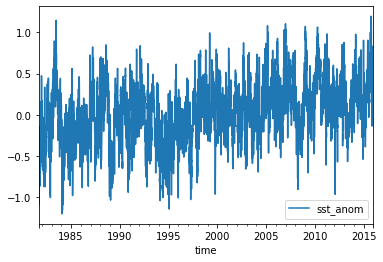

In [17]:
new_ts[0].plot("time", "sst_anom")

## Step 5: Export

**NOTE:**
Some of the large marine ecosystem names contain a hyphen, so added an extra step to replace those.

In [19]:
# NEW Code - should be good to test

# Paths to where the timelines go
mask_ts_paths = ot.get_timeseries_paths(box_root = box_root, 
                                        region_list = region_names, 
                                        region_group = update_regions, 
                                        polygons = False)

# Use the file paths we looked up before to set the save destinations
for updated_timeline_i, update_path_i in zip(new_ts, mask_ts_paths):
    # save them
    print(f"Saving: {update_path_i}")
    updated_timeline_i.to_csv(update_path_i, index = False)

Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_agulhas_current.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_aleutian_islands.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_antarctica.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_arabian_sea.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_baltic_sea.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_barents_sea.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems/OISSTv2_anom_bay_of_bengal.csv
Saving: /Users/akemberling/Box/RES_Data/OISST/

In [10]:
# # OLD Code - Information Constants

# # Timeseries destination folder
# out_folder = f"{box_root}RES_Data/OISST/oisst_mainstays/regional_timeseries/large_marine_ecosystems"

# # Anomaly grid name
# grid_name = "OISSTv2_anom"

# ##### Loop for all the LME's  ####
# for i, area in lme_info.iterrows():
    
#      # Fix the spaces and other characters in the name
#     mask_name = area["lme_name"].replace(" ", "_").replace(".", "").replace("-", "_").replace("___", "_").replace("__", "_").lower()  
    
    
#     # Path to the timeseries
#     out_path = f"{out_folder}/{grid_name}_{mask_name}.csv"
    
#     # print to check
#     #print(out_path)
    
#     # And export
#     new_ts[i].to_csv(out_path, index = False)